In [1]:
import argparse, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
parser = argparse.ArgumentParser(description="IMDN")
parser.add_argument("--block_size", type=int, default=64,
                    help="Block Size")
parser.add_argument("--crop_depth", type=int, default=30,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")

_StoreAction(option_strings=['--batch_size'], dest='batch_size', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, required=False, help='dataset_directory', metavar=None)

In [3]:
args = list(parser.parse_known_args())[0]

In [4]:
args.dir = "/storage/users/arihant"

In [5]:
args.batch_size = 4

In [6]:
args

Namespace(block_size=64, crop_depth=30, dir='/storage/users/arihant', batch_size=4)

In [7]:
import data.HCP_dataset

In [8]:
import utils
ids = utils.get_ids()

number of common Subjects  171


In [9]:
training_dataset = data.HCP_dataset.hcp_data(args,ids)

In [10]:
training_dataset.tot

171

In [11]:
import numpy as np
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset
    tot_len = len(dataset.ids)
    per_worker = int(tot_len / float(worker_info.num_workers))
    worker_id = worker_info.id
    dataset.ids = dataset.ids[worker_id * per_worker:max(((worker_id+1) * per_worker),tot_len )]
    dataset.curr_indx_blk = 0

    
def custom_collate(data):
    data = np.stack([data]).squeeze()
    data_gt = data[...,:8]
    data_pred = data[...,8:]
    return data_gt,data_pred

In [12]:
training_dataloader = torch.utils.data.DataLoader(training_dataset, num_workers=0,batch_size = 60,worker_init_fn=worker_init_fn,collate_fn=custom_collate)

In [13]:
for i in range(1):
    data = iter(training_dataloader)
    for j in data:
        print(j[0].shape,j[1].shape)

-1
100610 0


/home/arihant/DWI_SR/HCP_SR/data/utils_dataloader.py:147: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


(60, 64, 64, 64, 8) (60, 64, 64, 64, 7)


In [54]:
import utils
def blocks(mask):
    tmp = np.nonzero(mask);
    xind = tmp[0] * 1.0;
    yind = tmp[1] * 1.0;
    zind = tmp[2] * 1.0;

    xmin = np.min(xind); xmax = np.max(xind);
    ymin = np.min(yind); ymax = np.max(yind);
    zmin = np.min(zind); zmax = np.max(zind);
    ind_brain = [xmin, xmax, ymin, ymax, zmin, zmax]; 

    # calculate number of blocks along each dimension
    sz_block = 64
    xlen = xmax - xmin + 1;
    ylen = ymax - ymin + 1;
    zlen = zmax - zmin + 1;

    nx = int(np.ceil(xlen / sz_block));
    ny = int(np.ceil(ylen / sz_block));
    nz = int(np.ceil(zlen / sz_block));

    # determine starting and ending indices of each block
    xstart = xmin;
    ystart = ymin;
    zstart = zmin;

    xend = xmax - sz_block + 1;
    yend = ymax - sz_block + 1;
    zend = zmax - sz_block + 1;

    xind_block = np.round(np.linspace(xstart, xend, nx));
    yind_block = np.round(np.linspace(ystart, yend, ny));
    zind_block = np.round(np.linspace(zstart, zend, nz));

    ind_block = np.zeros([xind_block.shape[0]*yind_block.shape[0]*zind_block.shape[0], 6])
    count = 0
    for ii in np.arange(0, xind_block.shape[0]):
        for jj in np.arange(0, yind_block.shape[0]):
            for kk in np.arange(0, zind_block.shape[0]):
                ind_block[count, :] = np.array([xind_block[ii], xind_block[ii]+sz_block-1, yind_block[jj], yind_block[jj]+sz_block-1, zind_block[kk], zind_block[kk]+sz_block-1])
                count = count + 1

    ind_block = ind_block.astype(int);
    return ind_block

def dataloader_plotter(gt,pred,data_id,channel,offset):
    data,mask,scan,gtab,grad = utils.load_hcp(data_id,'3T',crop = 30)
    temp_gt = np.zeros((mask.shape))
    temp_pred = np.zeros((mask.shape))
    ind = blocks(mask)
    offset = offset * 12
    gt = gt[offset*12:(offset+1)*12,...]
    pred = pred[offset*12:(offset+1)*12,...]
    for ii in np.arange(ind.shape[0]):
        inds_this = ind[ii, :]
        temp_pred[inds_this[0]:inds_this[1]+1, inds_this[2]:inds_this[3]+1, inds_this[4]:inds_this[5]+1] = pred[ii,:,:,:,channel]
        temp_gt[inds_this[0]:inds_this[1]+1, inds_this[2]:inds_this[3]+1, inds_this[4]:inds_this[5]+1] = gt[ii,:,:,:,channel]
    return temp_gt,temp_pred

In [55]:
gt,pred = j

In [56]:
gt.shape

(60, 64, 64, 64, 8)

In [57]:
plt_gt,plt_pred = dataloader_plotter(gt,pred,'100610',2,0)

In [65]:
plt_gt.shape,plt_pred.shape

((145, 174, 85), (145, 174, 85))

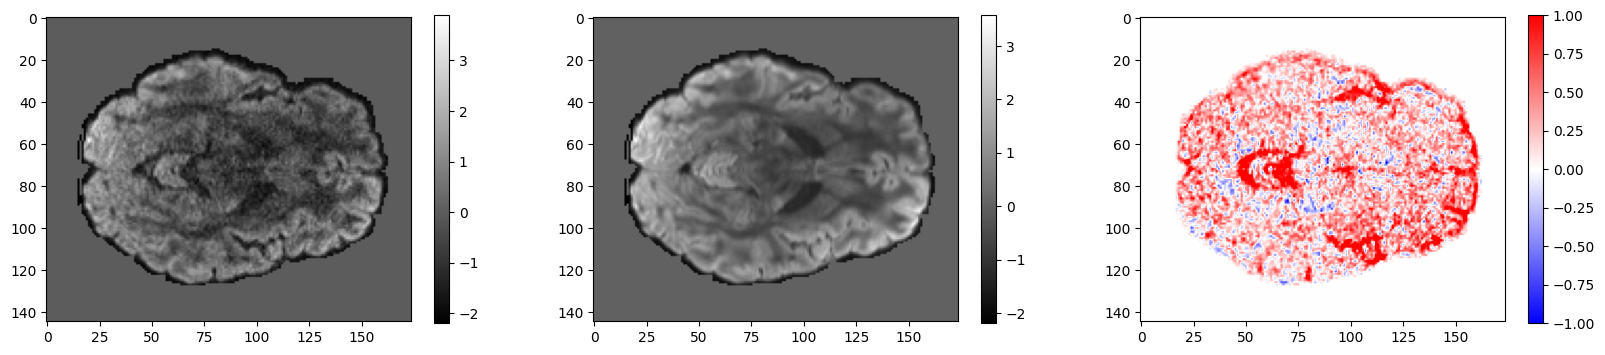

In [74]:
i=25
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)

im = axis[0].imshow(plt_pred[:,:,i], cmap='gray')
plt.colorbar(im, ax=axis[0],shrink = 0.4)
im = axis[1].imshow(plt_gt[:,:,i], cmap='gray')
plt.colorbar(im, ax=axis[1],shrink = 0.4)
im = axis[2].imshow(plt_gt[:,:,i] - plt_pred[:,:,i], clim=(-1., 1.), cmap='bwr')
plt.colorbar(im, ax=axis[2],shrink = 0.4)
# im = ax[i, j].imshow(data)